In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Using Theano backend.


In [2]:
portfolio_assets = ['CSCO', 'MSFT', 'IBM', 'GOOG', 'INTC']

In [3]:
def get_table(portfolio_assets, column):
    data = pd.DataFrame((pd.read_csv(portfolio_assets[0]+'_2Y.csv')).Date)
    for ticker in portfolio_assets:    
        file_name = ticker + '_2Y.csv'
        df = pd.read_csv(file_name)
        df = df[['Date', column]]  # column: open, high, low, close, volume...
        data = pd.merge(data, df, on='Date')
    data.columns = ['Date'] + portfolio_assets
    data.drop('Date', inplace=True, axis=1)
    
    return data

In [4]:
open_df = get_table(portfolio_assets=portfolio_assets, column='Open')
high_df = get_table(portfolio_assets=portfolio_assets, column='High')
low_df = get_table(portfolio_assets=portfolio_assets, column='Low')
close_df = get_table(portfolio_assets=portfolio_assets, column='Close')
close_df.head()

,CSCO,MSFT,IBM,GOOG,INTC
0,28.250000,55.360001,151.160004,753.200012,31.799999
1,27.900000,55.650002,151.720001,759.000000,31.459999
2,28.190001,56.459999,152.529999,766.609985,31.650000
3,28.330000,56.389999,144.000000,753.929993,31.600000
4,28.440001,55.590000,146.110001,752.669983,32.000000


Initial parameters for the portfolio

In [5]:
K = 10000  # initial capital
n_assets = len(portfolio_assets)  # number of assets in portfolio
weights = pd.Series(1/n_assets for i in range(n_assets))  # initial portfolio weights

# calculate annualized portfolio returns
returns = close_df.pct_change()
mean_daily_returns = pd.Series(returns.mean().values)
cov_matrix = returns.cov()

portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)
print(('Portfolio expected annualized return = {}\nand volatility = {}').format(portfolio_return,portfolio_std_dev))

Portfolio expected annualized return = 0.2
and volatility = 0.15


#### Perform Monte-Carlo Simulation to define the optimal assets' weights

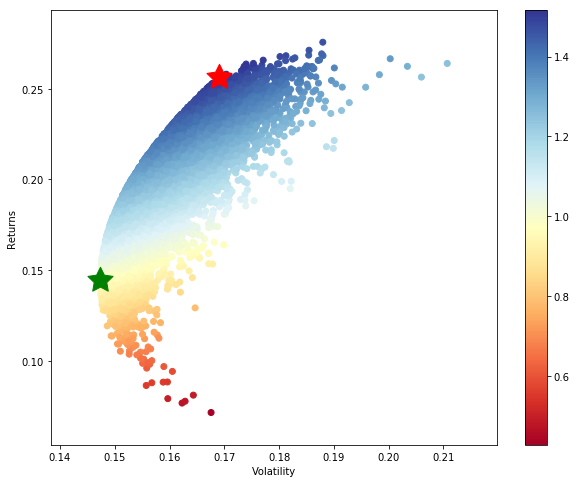

In [6]:
num_portfolios = 25000  # number of generations

# Store results to derive the best weight values for each stock after simulation 
results = np.zeros((4+len(portfolio_assets)-1,num_portfolios))

for i in range(num_portfolios):
    # set random weights for assets
    weights = np.array(np.random.random(5))
    # rebalance weights, that they in sum were equal to 1
    weights /= np.sum(weights)
    
    # calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252   # 252 - number of trading days in 1 year
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    # store results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    
    # store Sharpe Ratio values (return / volatility)
    results[2,i] = results[0,i] / results[1,i]
    
    # iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',portfolio_assets[0],
                                                portfolio_assets[1],portfolio_assets[2],
                                                portfolio_assets[3], portfolio_assets[4]])
 
# derive the portfolio with the highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

# derive the portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
 
# plot results
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

# red star - the position of portfolio with the highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=700)
# green star - the position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=700)

In [7]:
print('Max_Sharpe_ratio Portfolio:\n', max_sharpe_port)
print('-'*30)
print('Min_volatility Portfolio:\n', min_vol_port)

Max_Sharpe_ratio Portfolio:
 ret       0.256511
stdev     0.169121
sharpe    1.516729
CSCO      0.375185
MSFT      0.460331
IBM       0.010488
GOOG      0.004293
INTC      0.149703
Name: 18377, dtype: float64
------------------------------
Min_volatility Portfolio:
 ret       0.144556
stdev     0.147372
sharpe    0.980889
CSCO      0.278255
MSFT      0.046409
IBM       0.382578
GOOG      0.254011
INTC      0.038747
Name: 1427, dtype: float64


Dynamics of the portfolio within the specified amount of capital

In [8]:
K = 10000  # initial capital
n_assets = len(portfolio_assets)  # number of assets in the portfolio
max_sharpe_weights = max_sharpe_port.iloc[3:] # weights for portfolio with the highest Sharpe ratio

def build_portfolio(df, rebalance_window=14, initial_capital=10000, n_assets=5, i = 0):

    index_data = list()  # to store the portfolio performance
    K = np.array(initial_capital)
    price_values = pd.Series(df.iloc[i, :].values)
    assets_in_index = portfolio_assets
    w = pd.Series(max_sharpe_weights.values)

    assets_quantity = K * w / price_values   # amount of each asset in the portfolio

    index_volume = np.sum(assets_quantity * price_values)  # portfolio value over time
    index_data.append(index_volume)

    for i in range(1, df.shape[0]):
        price_values = df.loc[i, assets_in_index]
        price_values = pd.Series(price_values.values)
        index_volume = np.sum(assets_quantity * price_values)
        index_data.append(index_volume)
        
    return w, assets_quantity, index_data

In [9]:
# portfolios for OHLC values of each asset
w_open, assets_quantity_open, data_open = build_portfolio(open_df, rebalance_window=14,
                                                                   initial_capital=10000, n_assets=5)
w_high, assets_quantity_high, data_high = build_portfolio(high_df, rebalance_window=14,
                                                                   initial_capital=10000, n_assets=5)
w_low, assets_quantity_low, data_low = build_portfolio(low_df, rebalance_window=14,
                                                                   initial_capital=10000, n_assets=5)
w_close, assets_quantity_close, data_close = build_portfolio(close_df, rebalance_window=14,
                                                                   initial_capital=10000, n_assets=5)

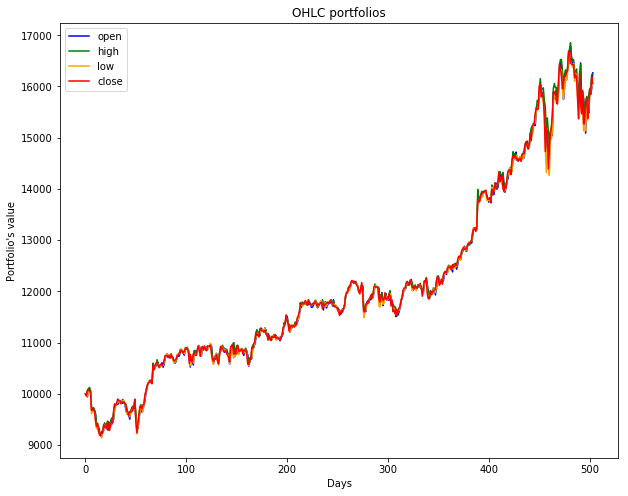

In [10]:
# plot OHLC portfolios
plt.plot(data_open, label='open', color='blue')
plt.plot(data_high, label='high', color='green')
plt.plot(data_low, label='low', color='orange')
plt.plot(data_close, label='close', color='red')
plt2.legend(loc='best')
plt2.title('OHLC portfolios')
plt2.xlabel('Days')
plt2.ylabel("Portfolio's value")
plt.show()

Build portfolio on each asset to compare with prepared portfolio

In [11]:
def sigle_asset_portfolio(asset_df, rebalance_window=14, initial_capital=10000, i = 0):

    index_data = list()
    K = np.array(initial_capital)
    price_values = pd.Series(asset_df[0])
    assets_quantity = K / price_values

    index_volume = np.sum(assets_quantity * price_values)
    index_data.append(index_volume)

    for i in range(1, asset_df.shape[0]):
        price_values = asset_df[i]
        price_values = pd.Series(price_values)
        index_volume = np.sum(assets_quantity * price_values)
        index_data.append(index_volume)
        
    return index_data

In [12]:
# single asset portfolios
csco_p = sigle_asset_portfolio(close_df.CSCO, rebalance_window=14, initial_capital=10000, i = 0)
msft_p = sigle_asset_portfolio(close_df.MSFT, rebalance_window=14, initial_capital=10000, i = 0)
ibm_p = sigle_asset_portfolio(close_df.IBM, rebalance_window=14, initial_capital=10000, i = 0)
goog_p = sigle_asset_portfolio(close_df.GOOG, rebalance_window=14, initial_capital=10000, i = 0)
intc_p = sigle_asset_portfolio(close_df.INTC, rebalance_window=14, initial_capital=10000, i = 0)

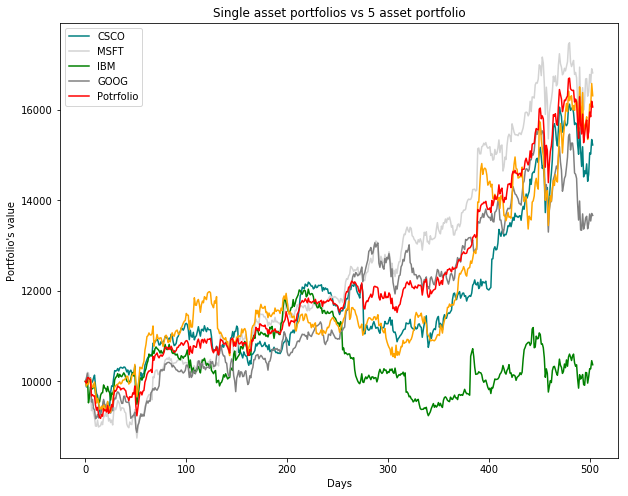

In [13]:
# plot single asset portfolios and chosen portfolio of 5 assets
plt.plot(csco_p, label='CSCO', color='teal')
plt.plot(msft_p, label='MSFT', color='lightgray')
plt.plot(ibm_p, label='IBM', color='green')
plt.plot(goog_p, label='GOOG', color='gray')
plt.plot(intc_p, color='orange')
plt.plot(data_close, label='Potrfolio', color='red')
plt2.legend(loc='best')
plt2.title('Single asset portfolios vs 5 asset portfolio')
plt2.xlabel('Days')
plt2.ylabel("Portfolio's value")
plt.show()

Build comprehensive portfolio table (OHLC)

In [14]:
data_open = pd.Series(data_open)
data_high = pd.Series(data_high)
data_low = pd.Series(data_low)
data_close = pd.Series(data_close)

In [15]:
frames = [data_open, data_high, data_low, data_close]
df_portfolio = pd.read_csv(portfolio_assets[0]+'_2Y.csv')
df_portfolio = pd.DataFrame(df_portfolio.Date)

for i in frames:
    df_portfolio = df_portfolio.merge(i.to_frame(), left_index=True, right_index=True)
    
df_portfolio.columns = [['Date', 'Open', 'High', 'Low', 'Close']]
df_portfolio = df_portfolio.iloc[:, 1:]
df_portfolio.head()

,Open,High,Low,Close
0,10000.000000,10000.000000,10000.000000,10000.000000
1,9969.803725,9992.246393,9946.279551,9962.344253
2,9943.084328,10056.724352,9964.616854,10078.152355
3,10104.563793,10096.812930,10051.612911,10081.929806
4,10065.374977,10126.785459,10037.632720,10050.239953


In [16]:
# perform normalization so that values will lie in the interval from 0 to 1
min_max_scaler = preprocessing.MinMaxScaler()
df_portfolio['Open'] = min_max_scaler.fit_transform(df_portfolio.Open.values.reshape(-1,1))
df_portfolio['High'] = min_max_scaler.fit_transform(df_portfolio.Open.values.reshape(-1,1))
df_portfolio['Low'] = min_max_scaler.fit_transform(df_portfolio.Open.values.reshape(-1,1))        
df_portfolio['Close'] = min_max_scaler.fit_transform(df_portfolio.Open.values.reshape(-1,1))

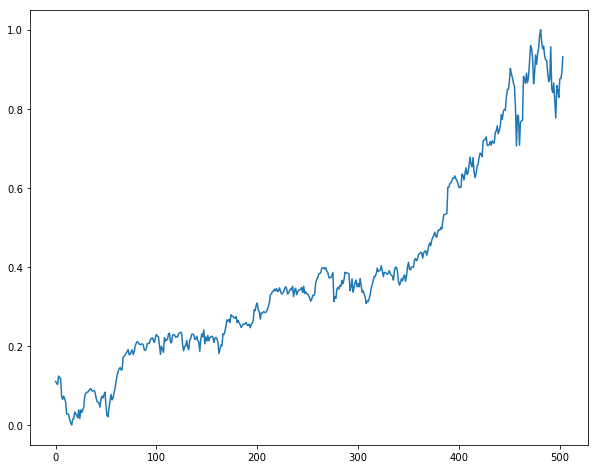

In [17]:
plt.plot(df_portfolio.Close)
plt.show()

#### Build the LSTM

In [18]:
# model parameters
window_size = 22 # as a common trading month
d = 0.7 # dropout parameter
shape = [4, window_size, 1] # feature, window_size, output
neurons = [128, 128, 32, 1]
epochs = 70

Set last day Close as y

In [19]:
def load_data(df_portfolio, window_size):
    
    amount_of_features = len(df_portfolio.columns)
    data = df_portfolio.as_matrix()
    sequence_length = window_size + 1
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
            result.append(data[index: index + sequence_length]) # index : index + 22 days as window_size 

    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day y
    y_train = train[:, -1][:,-1] # day y + 1 close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [20]:
X_train, y_train, X_test, y_test = load_data(df_portfolio, window_size)

In [21]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(433, 22, 4)

In [22]:
y_train.shape

(433,)

#### Buidling LSTM NN

In [23]:
def build_model(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

###### Model Execution

In [24]:
model = build_model(shape, neurons, d)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=epochs,
    validation_split=0.1,
    verbose=2)

Train on 389 samples, validate on 44 samples
Epoch 1/70
1s - loss: 0.1009 - acc: 0.0000e+00 - val_loss: 0.3795 - val_acc: 0.0000e+00
Epoch 2/70
1s - loss: 0.0373 - acc: 0.0000e+00 - val_loss: 0.0792 - val_acc: 0.0000e+00
Epoch 3/70
1s - loss: 0.0170 - acc: 0.0000e+00 - val_loss: 0.1999 - val_acc: 0.0000e+00
Epoch 4/70
2s - loss: 0.0143 - acc: 0.0000e+00 - val_loss: 0.1318 - val_acc: 0.0000e+00
Epoch 5/70
2s - loss: 0.0091 - acc: 0.0000e+00 - val_loss: 0.0943 - val_acc: 0.0000e+00
Epoch 6/70
2s - loss: 0.0070 - acc: 0.0000e+00 - val_loss: 0.0694 - val_acc: 0.0000e+00
Epoch 7/70
3s - loss: 0.0053 - acc: 0.0000e+00 - val_loss: 0.0266 - val_acc: 0.0000e+00
Epoch 8/70
3s - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0210 - val_acc: 0.0000e+00
Epoch 9/70
3s - loss: 0.0043 - acc: 0.0000e+00 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 10/70
4s - loss: 0.0034 - acc: 0.0000e+00 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 11/70
4s - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0189 - val_a

#### Result on training set and testing set

In [26]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [27]:
trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00079 MSE (0.03 RMSE)
Test Score: 0.00485 MSE (0.07 RMSE)


#### Prediction vs Actual values

In [28]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [29]:
p_test = percentage_difference(model, X_test, y_test)
p_train = percentage_difference(model, X_train, y_train)

#### Plot out prediction

In [30]:
def denormalize(df_portfolio, normalized_value):
    df_to_plot = df_portfolio.values.reshape(-1,1)
    
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df_to_plot)
    new = min_max_scaler.inverse_transform(normalized_value)
    
    return new

In [31]:
def plot_result(df_portfolio, normalized_value_p, normalized_value_y_test):
    newp = denormalize(df_portfolio, normalized_value_p)
    newy_test = denormalize(df_portfolio, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(df_portfolio))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

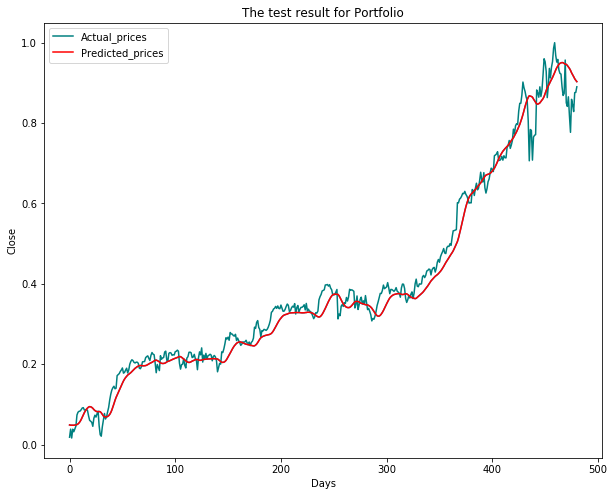

In [32]:
test_diff = denormalize(df_portfolio, p_test)
train_diff = denormalize(df_portfolio, p_train)
diff = np.append(train_diff, test_diff)
plt.plot(diff)

actual_test = denormalize(df_portfolio, y_test)
actual_train = denormalize(df_portfolio, y_train)
actual = np.append(actual_train, actual_test)

plt.plot(actual, label = 'Actual_prices', color = 'teal')
plt.plot(diff, label = 'Predicted_prices', color = 'red')
plt2.legend(loc='best')
plt2.title('The test result for Portfolio')
plt2.xlabel('Days')
plt2.ylabel('Close')
plt2.show()

In [33]:
model.save('LSTM_Portfolio_prediction-20170429.h5')

### Tune model

In [42]:
window_size = 22
shape = [4, window_size, 1]
neurons = [128, 128, 32, 1]
epochs = 300

In [69]:
def quick_measure(file_csv_name, window_size, d, shape, neurons, epochs, decay):
    df = get_stock_price(file_csv_name)
    X_train, y_train, X_test, y_test = load_data(df, window_size)
    
    model = build_model2(shape, neurons, d, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

Optimial Dropout value

In [72]:
batch_size = 512
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs)
    dropout_result[d] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 120, 32)           4736      
_________________________________________________________________
dropout_97 (Dropout)         (None, 120, 32)           0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_98 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

310/310 [==============================] - 7s - loss: 0.1159 - acc: 0.0000e+00 - val_loss: 0.5487 - val_acc: 0.0000e+00
Epoch 6/100
310/310 [==============================] - 7s - loss: 0.1149 - acc: 0.0000e+00 - val_loss: 0.5454 - val_acc: 0.0000e+00
Epoch 7/100
310/310 [==============================] - 6s - loss: 0.1138 - acc: 0.0000e+00 - val_loss: 0.5416 - val_acc: 0.0000e+00
Epoch 8/100
310/310 [==============================] - 6s - loss: 0.1125 - acc: 0.0000e+00 - val_loss: 0.5371 - val_acc: 0.0000e+00
Epoch 9/100
310/310 [==============================] - 6s - loss: 0.1110 - acc: 0.0000e+00 - val_loss: 0.5319 - val_acc: 0.0000e+00
Epoch 10/100
310/310 [==============================] - 6s - loss: 0.1094 - acc: 0.0000e+00 - val_loss: 0.5257 - val_acc: 0.0000e+00
Epoch 11/100
310/310 [==============================] - 6s - loss: 0.1075 - acc: 0.0000e+00 - val_loss: 0.5184 - val_acc: 0.0000e+00
Epoch 12/100
310/310 [==============================] - 6s - loss: 0.1052 - acc: 0.000

310/310 [==============================] - 6s - loss: 0.0767 - acc: 0.0000e+00 - val_loss: 0.4191 - val_acc: 0.0000e+00
Epoch 19/100
310/310 [==============================] - 7s - loss: 0.0707 - acc: 0.0000e+00 - val_loss: 0.4023 - val_acc: 0.0000e+00
Epoch 20/100
310/310 [==============================] - 7s - loss: 0.0643 - acc: 0.0000e+00 - val_loss: 0.3849 - val_acc: 0.0000e+00
Epoch 21/100
310/310 [==============================] - 7s - loss: 0.0580 - acc: 0.0000e+00 - val_loss: 0.3669 - val_acc: 0.0000e+00
Epoch 22/100
310/310 [==============================] - 7s - loss: 0.0509 - acc: 0.0000e+00 - val_loss: 0.3483 - val_acc: 0.0000e+00
Epoch 23/100
310/310 [==============================] - 8s - loss: 0.0452 - acc: 0.0000e+00 - val_loss: 0.3287 - val_acc: 0.0000e+00
Epoch 24/100
310/310 [==============================] - 7s - loss: 0.0390 - acc: 0.0000e+00 - val_loss: 0.3089 - val_acc: 0.0000e+00
Epoch 25/100
310/310 [==============================] - 7s - loss: 0.0337 - acc: 0

310/310 [==============================] - 7s - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.2165 - val_acc: 0.0000e+00
Epoch 32/100
310/310 [==============================] - 6s - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.1964 - val_acc: 0.0000e+00
Epoch 33/100
310/310 [==============================] - 6s - loss: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1775 - val_acc: 0.0000e+00
Epoch 34/100
310/310 [==============================] - 6s - loss: 0.0152 - acc: 0.0000e+00 - val_loss: 0.1607 - val_acc: 0.0000e+00
Epoch 35/100
310/310 [==============================] - 7s - loss: 0.0138 - acc: 0.0000e+00 - val_loss: 0.1465 - val_acc: 0.0000e+00
Epoch 36/100
310/310 [==============================] - 7s - loss: 0.0153 - acc: 0.0000e+00 - val_loss: 0.1360 - val_acc: 0.0000e+00
Epoch 37/100
310/310 [==============================] - 6s - loss: 0.0177 - acc: 0.0000e+00 - val_loss: 0.1291 - val_acc: 0.0000e+00
Epoch 38/100
310/310 [==============================] - 7s - loss: 0.0180 - acc: 0

310/310 [==============================] - 7s - loss: 0.0153 - acc: 0.0000e+00 - val_loss: 0.2031 - val_acc: 0.0000e+00
Epoch 45/100
310/310 [==============================] - 7s - loss: 0.0144 - acc: 0.0000e+00 - val_loss: 0.2062 - val_acc: 0.0000e+00
Epoch 46/100
310/310 [==============================] - 7s - loss: 0.0160 - acc: 0.0000e+00 - val_loss: 0.2082 - val_acc: 0.0000e+00
Epoch 47/100
310/310 [==============================] - 7s - loss: 0.0159 - acc: 0.0000e+00 - val_loss: 0.2093 - val_acc: 0.0000e+00
Epoch 48/100
310/310 [==============================] - 7s - loss: 0.0157 - acc: 0.0000e+00 - val_loss: 0.2093 - val_acc: 0.0000e+00
Epoch 49/100
310/310 [==============================] - 7s - loss: 0.0151 - acc: 0.0000e+00 - val_loss: 0.2085 - val_acc: 0.0000e+00
Epoch 50/100
310/310 [==============================] - 7s - loss: 0.0149 - acc: 0.0000e+00 - val_loss: 0.2067 - val_acc: 0.0000e+00
Epoch 51/100
310/310 [==============================] - 7s - loss: 0.0156 - acc: 0

Train on 310 samples, validate on 35 samples
Epoch 1/100
310/310 [==============================] - 57s - loss: 0.1193 - acc: 0.0000e+00 - val_loss: 0.5589 - val_acc: 0.0000e+00
Epoch 2/100
310/310 [==============================] - 10s - loss: 0.1183 - acc: 0.0000e+00 - val_loss: 0.5557 - val_acc: 0.0000e+00
Epoch 3/100
310/310 [==============================] - 10s - loss: 0.1171 - acc: 0.0000e+00 - val_loss: 0.5524 - val_acc: 0.0000e+00
Epoch 4/100
310/310 [==============================] - 10s - loss: 0.1160 - acc: 0.0000e+00 - val_loss: 0.5487 - val_acc: 0.0000e+00
Epoch 5/100
310/310 [==============================] - 10s - loss: 0.1146 - acc: 0.0000e+00 - val_loss: 0.5445 - val_acc: 0.0000e+00
Epoch 6/100
310/310 [==============================] - 10s - loss: 0.1132 - acc: 0.0000e+00 - val_loss: 0.5396 - val_acc: 0.0000e+00
Epoch 7/100
310/310 [==============================] - 10s - loss: 0.1117 - acc: 0.0000e+00 - val_loss: 0.5341 - val_acc: 0.0000e+00
Epoch 8/100
310/310 [===

310/310 [==============================] - 7s - loss: 0.1035 - acc: 0.0000e+00 - val_loss: 0.5054 - val_acc: 0.0000e+00
Epoch 15/100
310/310 [==============================] - 7s - loss: 0.1012 - acc: 0.0000e+00 - val_loss: 0.4969 - val_acc: 0.0000e+00
Epoch 16/100
310/310 [==============================] - 7s - loss: 0.0985 - acc: 0.0000e+00 - val_loss: 0.4873 - val_acc: 0.0000e+00
Epoch 17/100
310/310 [==============================] - 7s - loss: 0.0950 - acc: 0.0000e+00 - val_loss: 0.4766 - val_acc: 0.0000e+00
Epoch 18/100
310/310 [==============================] - 7s - loss: 0.0912 - acc: 0.0000e+00 - val_loss: 0.4646 - val_acc: 0.0000e+00
Epoch 19/100
310/310 [==============================] - 7s - loss: 0.0887 - acc: 0.0000e+00 - val_loss: 0.4514 - val_acc: 0.0000e+00
Epoch 20/100
310/310 [==============================] - 7s - loss: 0.0831 - acc: 0.0000e+00 - val_loss: 0.4372 - val_acc: 0.0000e+00
Epoch 21/100
310/310 [==============================] - 7s - loss: 0.0775 - acc: 0

Find the best dropout parameter

In [73]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print(dropout_result)
print(min_val_key)

{0.2: 0.28307063250165238, 0.3: 0.32187784267099279, 0.4: 0.30487769606866333, 0.5: 0.31210789006007345, 0.6: 0.29026408571945994, 0.7: 0.21538778590528587, 0.8: 0.35243767343069377}
[0.7]


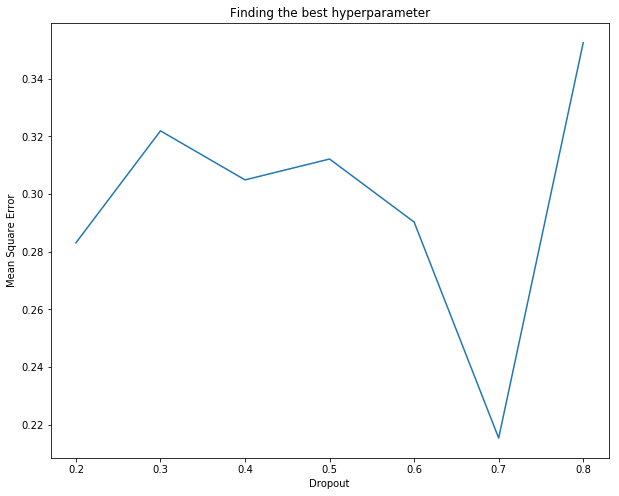

In [74]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

Optimial epochs value

In [75]:
batch_size = 512
epochslist = [10,20,30,40,50,60,70,80,90,100]
d = 0.7

In [76]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs)
    epochs_result[epochs] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_111 (LSTM)              (None, 120, 32)           4736      
_________________________________________________________________
dropout_111 (Dropout)        (None, 120, 32)           0         
_________________________________________________________________
lstm_112 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dropout_112 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

310/310 [==============================] - 8s - loss: 0.0204 - acc: 0.0000e+00 - val_loss: 0.1357 - val_acc: 0.0000e+00
Epoch 28/40
310/310 [==============================] - 7s - loss: 0.0221 - acc: 0.0000e+00 - val_loss: 0.1278 - val_acc: 0.0000e+00
Epoch 29/40
310/310 [==============================] - 8s - loss: 0.0257 - acc: 0.0000e+00 - val_loss: 0.1244 - val_acc: 0.0000e+00
Epoch 30/40
310/310 [==============================] - 8s - loss: 0.0247 - acc: 0.0000e+00 - val_loss: 0.1245 - val_acc: 0.0000e+00
Epoch 31/40
310/310 [==============================] - 7s - loss: 0.0259 - acc: 0.0000e+00 - val_loss: 0.1276 - val_acc: 0.0000e+00
Epoch 32/40
310/310 [==============================] - 7s - loss: 0.0238 - acc: 0.0000e+00 - val_loss: 0.1331 - val_acc: 0.0000e+00
Epoch 33/40
310/310 [==============================] - 7s - loss: 0.0220 - acc: 0.0000e+00 - val_loss: 0.1403 - val_acc: 0.0000e+00
Epoch 34/40
310/310 [==============================] - 7s - loss: 0.0254 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0224 - acc: 0.0000e+00 - val_loss: 0.1744 - val_acc: 0.0000e+00
Epoch 42/60
310/310 [==============================] - 7s - loss: 0.0204 - acc: 0.0000e+00 - val_loss: 0.1821 - val_acc: 0.0000e+00
Epoch 43/60
310/310 [==============================] - 7s - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.1894 - val_acc: 0.0000e+00
Epoch 44/60
310/310 [==============================] - 8s - loss: 0.0170 - acc: 0.0000e+00 - val_loss: 0.1959 - val_acc: 0.0000e+00
Epoch 45/60
310/310 [==============================] - 8s - loss: 0.0179 - acc: 0.0000e+00 - val_loss: 0.2019 - val_acc: 0.0000e+00
Epoch 46/60
310/310 [==============================] - 7s - loss: 0.0180 - acc: 0.0000e+00 - val_loss: 0.2068 - val_acc: 0.0000e+00
Epoch 47/60
310/310 [==============================] - 8s - loss: 0.0201 - acc: 0.0000e+00 - val_loss: 0.2112 - val_acc: 0.0000e+00
Epoch 48/60
310/310 [==============================] - 7s - loss: 0.0170 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0699 - acc: 0.0000e+00 - val_loss: 0.3860 - val_acc: 0.0000e+00
Epoch 16/80
310/310 [==============================] - 8s - loss: 0.0617 - acc: 0.0000e+00 - val_loss: 0.3633 - val_acc: 0.0000e+00
Epoch 17/80
310/310 [==============================] - 8s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.3397 - val_acc: 0.0000e+00
Epoch 18/80
310/310 [==============================] - 8s - loss: 0.0464 - acc: 0.0000e+00 - val_loss: 0.3154 - val_acc: 0.0000e+00
Epoch 19/80
310/310 [==============================] - 8s - loss: 0.0401 - acc: 0.0000e+00 - val_loss: 0.2908 - val_acc: 0.0000e+00
Epoch 20/80
310/310 [==============================] - 8s - loss: 0.0324 - acc: 0.0000e+00 - val_loss: 0.2661 - val_acc: 0.0000e+00
Epoch 21/80
310/310 [==============================] - 8s - loss: 0.0291 - acc: 0.0000e+00 - val_loss: 0.2417 - val_acc: 0.0000e+00
Epoch 22/80
310/310 [==============================] - 8s - loss: 0.0233 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0180 - acc: 0.0000e+00 - val_loss: 0.2191 - val_acc: 0.0000e+00
Epoch 50/90
310/310 [==============================] - 8s - loss: 0.0178 - acc: 0.0000e+00 - val_loss: 0.2194 - val_acc: 0.0000e+00
Epoch 51/90
310/310 [==============================] - 8s - loss: 0.0164 - acc: 0.0000e+00 - val_loss: 0.2187 - val_acc: 0.0000e+00
Epoch 52/90
310/310 [==============================] - 8s - loss: 0.0201 - acc: 0.0000e+00 - val_loss: 0.2171 - val_acc: 0.0000e+00
Epoch 53/90
310/310 [==============================] - 8s - loss: 0.0195 - acc: 0.0000e+00 - val_loss: 0.2150 - val_acc: 0.0000e+00
Epoch 54/90
310/310 [==============================] - 8s - loss: 0.0188 - acc: 0.0000e+00 - val_loss: 0.2123 - val_acc: 0.0000e+00
Epoch 55/90
310/310 [==============================] - 8s - loss: 0.0192 - acc: 0.0000e+00 - val_loss: 0.2092 - val_acc: 0.0000e+00
Epoch 56/90
310/310 [==============================] - 8s - loss: 0.0182 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0184 - acc: 0.0000e+00 - val_loss: 0.1830 - val_acc: 0.0000e+00
Epoch 73/100
310/310 [==============================] - 8s - loss: 0.0153 - acc: 0.0000e+00 - val_loss: 0.1843 - val_acc: 0.0000e+00
Epoch 74/100
310/310 [==============================] - 8s - loss: 0.0169 - acc: 0.0000e+00 - val_loss: 0.1857 - val_acc: 0.0000e+00
Epoch 75/100
310/310 [==============================] - 9s - loss: 0.0164 - acc: 0.0000e+00 - val_loss: 0.1873 - val_acc: 0.0000e+00
Epoch 76/100
310/310 [==============================] - 8s - loss: 0.0191 - acc: 0.0000e+00 - val_loss: 0.1889 - val_acc: 0.0000e+00
Epoch 77/100
310/310 [==============================] - 8s - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.1904 - val_acc: 0.0000e+00
Epoch 78/100
310/310 [==============================] - 8s - loss: 0.0151 - acc: 0.0000e+00 - val_loss: 0.1920 - val_acc: 0.0000e+00
Epoch 79/100
310/310 [==============================] - 8s - loss: 0.0159 - acc: 0

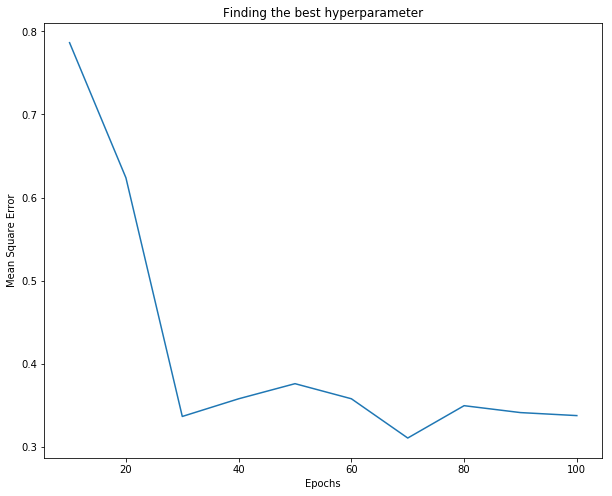

In [77]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

In [78]:
min_val_epochs = min(epochs_result.values())
min_val_epochs_key = [k for k, v in epochs_result.items() if v == min_val_epochs]
print ('MSE:', min_val_epochs)
print ('Number epochs:', min_val_epochs_key)

MSE: 0.310454328593
Number epochs: [70]


Optimal number of neurons

In [79]:
batch_size = 512
epochs = 70
dropout = 0.7
neuronlist1 = [32, 64, 128, 256, 512]
neuronlist2 = [16, 32, 64]
neurons_result = {}

for neuron_lstm in neuronlist1:
    neurons = [neuron_lstm, neuron_lstm]
    for activation in neuronlist2:
        neurons.append(activation)
        neurons.append(1)
        trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs)
        neurons_result[str(neurons)] = testScore
        neurons = neurons[:2]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 120, 32)           4736      
_________________________________________________________________
dropout_131 (Dropout)        (None, 120, 32)           0         
_________________________________________________________________
lstm_132 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dropout_132 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

310/310 [==============================] - 8s - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.1943 - val_acc: 0.0000e+00
Epoch 37/70
310/310 [==============================] - 8s - loss: 0.0184 - acc: 0.0000e+00 - val_loss: 0.2023 - val_acc: 0.0000e+00
Epoch 38/70
310/310 [==============================] - 8s - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.2088 - val_acc: 0.0000e+00
Epoch 39/70
310/310 [==============================] - 8s - loss: 0.0184 - acc: 0.0000e+00 - val_loss: 0.2137 - val_acc: 0.0000e+00
Epoch 40/70
310/310 [==============================] - 7s - loss: 0.0197 - acc: 0.0000e+00 - val_loss: 0.2169 - val_acc: 0.0000e+00
Epoch 41/70
310/310 [==============================] - 8s - loss: 0.0175 - acc: 0.0000e+00 - val_loss: 0.2187 - val_acc: 0.0000e+00
Epoch 42/70
310/310 [==============================] - 8s - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.2192 - val_acc: 0.0000e+00
Epoch 43/70
310/310 [==============================] - 8s - loss: 0.0179 - acc: 0.0000e+

310/310 [==============================] - 58s - loss: 0.1200 - acc: 0.0000e+00 - val_loss: 0.5576 - val_acc: 0.0000e+00
Epoch 2/70
310/310 [==============================] - 21s - loss: 0.1185 - acc: 0.0000e+00 - val_loss: 0.5538 - val_acc: 0.0000e+00
Epoch 3/70
310/310 [==============================] - 20s - loss: 0.1173 - acc: 0.0000e+00 - val_loss: 0.5495 - val_acc: 0.0000e+00
Epoch 4/70
310/310 [==============================] - 20s - loss: 0.1159 - acc: 0.0000e+00 - val_loss: 0.5445 - val_acc: 0.0000e+00
Epoch 5/70
310/310 [==============================] - 19s - loss: 0.1144 - acc: 0.0000e+00 - val_loss: 0.5388 - val_acc: 0.0000e+00
Epoch 6/70
310/310 [==============================] - 19s - loss: 0.1124 - acc: 0.0000e+00 - val_loss: 0.5317 - val_acc: 0.0000e+00
Epoch 7/70
310/310 [==============================] - 19s - loss: 0.1105 - acc: 0.0000e+00 - val_loss: 0.5231 - val_acc: 0.0000e+00
Epoch 8/70
310/310 [==============================] - 19s - loss: 0.1079 - acc: 0.0000e

310/310 [==============================] - 20s - loss: 0.0151 - acc: 0.0000e+00 - val_loss: 0.1675 - val_acc: 0.0000e+00
Epoch 45/70
310/310 [==============================] - 21s - loss: 0.0151 - acc: 0.0000e+00 - val_loss: 0.1713 - val_acc: 0.0000e+00
Epoch 46/70
310/310 [==============================] - 20s - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.1751 - val_acc: 0.0000e+00
Epoch 47/70
310/310 [==============================] - 22s - loss: 0.0148 - acc: 0.0000e+00 - val_loss: 0.1787 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 20s - loss: 0.0144 - acc: 0.0000e+00 - val_loss: 0.1819 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 21s - loss: 0.0144 - acc: 0.0000e+00 - val_loss: 0.1847 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 20s - loss: 0.0149 - acc: 0.0000e+00 - val_loss: 0.1870 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 21s - loss: 0.0148 - acc: 

310/310 [==============================] - 28s - loss: 0.0638 - acc: 0.0000e+00 - val_loss: 0.3359 - val_acc: 0.0000e+00
Epoch 9/70
310/310 [==============================] - 28s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.2939 - val_acc: 0.0000e+00
Epoch 10/70
310/310 [==============================] - 28s - loss: 0.0301 - acc: 0.0000e+00 - val_loss: 0.2538 - val_acc: 0.0000e+00
Epoch 11/70
310/310 [==============================] - 29s - loss: 0.0220 - acc: 0.0000e+00 - val_loss: 0.2138 - val_acc: 0.0000e+00
Epoch 12/70
310/310 [==============================] - 30s - loss: 0.0158 - acc: 0.0000e+00 - val_loss: 0.1754 - val_acc: 0.0000e+00
Epoch 13/70
310/310 [==============================] - 27s - loss: 0.0148 - acc: 0.0000e+00 - val_loss: 0.1437 - val_acc: 0.0000e+00
Epoch 14/70
310/310 [==============================] - 28s - loss: 0.0156 - acc: 0.0000e+00 - val_loss: 0.1254 - val_acc: 0.0000e+00
Epoch 15/70
310/310 [==============================] - 27s - loss: 0.0189 - acc: 0

310/310 [==============================] - 34s - loss: 0.0129 - acc: 0.0000e+00 - val_loss: 0.1595 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 31s - loss: 0.0130 - acc: 0.0000e+00 - val_loss: 0.1577 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 31s - loss: 0.0128 - acc: 0.0000e+00 - val_loss: 0.1571 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 31s - loss: 0.0127 - acc: 0.0000e+00 - val_loss: 0.1576 - val_acc: 0.0000e+00
Epoch 55/70
310/310 [==============================] - 33s - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.1589 - val_acc: 0.0000e+00
Epoch 56/70
310/310 [==============================] - 32s - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.1600 - val_acc: 0.0000e+00
Epoch 57/70
310/310 [==============================] - 32s - loss: 0.0127 - acc: 0.0000e+00 - val_loss: 0.1604 - val_acc: 0.0000e+00
Epoch 58/70
310/310 [==============================] - 32s - loss: 0.0129 - acc: 

310/310 [==============================] - 46s - loss: 0.0164 - acc: 0.0000e+00 - val_loss: 0.2251 - val_acc: 0.0000e+00
Epoch 16/70
310/310 [==============================] - 45s - loss: 0.0159 - acc: 0.0000e+00 - val_loss: 0.2118 - val_acc: 0.0000e+00
Epoch 17/70
310/310 [==============================] - 43s - loss: 0.0146 - acc: 0.0000e+00 - val_loss: 0.1964 - val_acc: 0.0000e+00
Epoch 18/70
310/310 [==============================] - 44s - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.1805 - val_acc: 0.0000e+00
Epoch 19/70
310/310 [==============================] - 44s - loss: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1671 - val_acc: 0.0000e+00
Epoch 20/70
310/310 [==============================] - 43s - loss: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1586 - val_acc: 0.0000e+00
Epoch 21/70
310/310 [==============================] - 44s - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.1550 - val_acc: 0.0000e+00
Epoch 22/70
310/310 [==============================] - 44s - loss: 0.0151 - acc: 

Train on 310 samples, validate on 35 samples
Epoch 1/70
310/310 [==============================] - 110s - loss: 0.1205 - acc: 0.0000e+00 - val_loss: 0.5413 - val_acc: 0.0000e+00
Epoch 2/70
310/310 [==============================] - 47s - loss: 0.1147 - acc: 0.0000e+00 - val_loss: 0.5060 - val_acc: 0.0000e+00
Epoch 3/70
310/310 [==============================] - 46s - loss: 0.1064 - acc: 0.0000e+00 - val_loss: 0.4317 - val_acc: 0.0000e+00
Epoch 4/70
310/310 [==============================] - 47s - loss: 0.0880 - acc: 0.0000e+00 - val_loss: 0.2964 - val_acc: 0.0000e+00
Epoch 5/70
310/310 [==============================] - 47s - loss: 0.0498 - acc: 0.0000e+00 - val_loss: 0.1663 - val_acc: 0.0000e+00
Epoch 6/70
310/310 [==============================] - 48s - loss: 0.0110 - acc: 0.0000e+00 - val_loss: 0.0875 - val_acc: 0.0000e+00
Epoch 7/70
310/310 [==============================] - 48s - loss: 0.0284 - acc: 0.0000e+00 - val_loss: 0.0972 - val_acc: 0.0000e+00
Epoch 8/70
310/310 [==========

310/310 [==============================] - 48s - loss: 0.0044 - acc: 0.0000e+00 - val_loss: 0.0406 - val_acc: 0.0000e+00
Epoch 45/70
310/310 [==============================] - 48s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0369 - val_acc: 0.0000e+00
Epoch 46/70
310/310 [==============================] - 50s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0305 - val_acc: 0.0000e+00
Epoch 47/70
310/310 [==============================] - 49s - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0238 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 47s - loss: 0.0039 - acc: 0.0000e+00 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 48s - loss: 0.0039 - acc: 0.0000e+00 - val_loss: 0.0138 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 49s - loss: 0.0034 - acc: 0.0000e+00 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 48s - loss: 0.0033 - acc: 

310/310 [==============================] - 85s - loss: 0.0200 - acc: 0.0000e+00 - val_loss: 0.2189 - val_acc: 0.0000e+00
Epoch 9/70
310/310 [==============================] - 87s - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.1961 - val_acc: 0.0000e+00
Epoch 10/70
310/310 [==============================] - 86s - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.1744 - val_acc: 0.0000e+00
Epoch 11/70
310/310 [==============================] - 89s - loss: 0.0124 - acc: 0.0000e+00 - val_loss: 0.1579 - val_acc: 0.0000e+00
Epoch 12/70
310/310 [==============================] - 86s - loss: 0.0133 - acc: 0.0000e+00 - val_loss: 0.1501 - val_acc: 0.0000e+00
Epoch 13/70
310/310 [==============================] - 87s - loss: 0.0146 - acc: 0.0000e+00 - val_loss: 0.1512 - val_acc: 0.0000e+00
Epoch 14/70
310/310 [==============================] - 86s - loss: 0.0143 - acc: 0.0000e+00 - val_loss: 0.1577 - val_acc: 0.0000e+00
Epoch 15/70
310/310 [==============================] - 86s - loss: 0.0138 - acc: 0

310/310 [==============================] - 91s - loss: 0.0028 - acc: 0.0000e+00 - val_loss: 0.0122 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 91s - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 98s - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 93s - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 55/70
310/310 [==============================] - 90s - loss: 0.0027 - acc: 0.0000e+00 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 56/70
310/310 [==============================] - 88s - loss: 0.0028 - acc: 0.0000e+00 - val_loss: 0.0149 - val_acc: 0.0000e+00
Epoch 57/70
310/310 [==============================] - 90s - loss: 0.0027 - acc: 0.0000e+00 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 58/70
310/310 [==============================] - 91s - loss: 0.0027 - acc: 

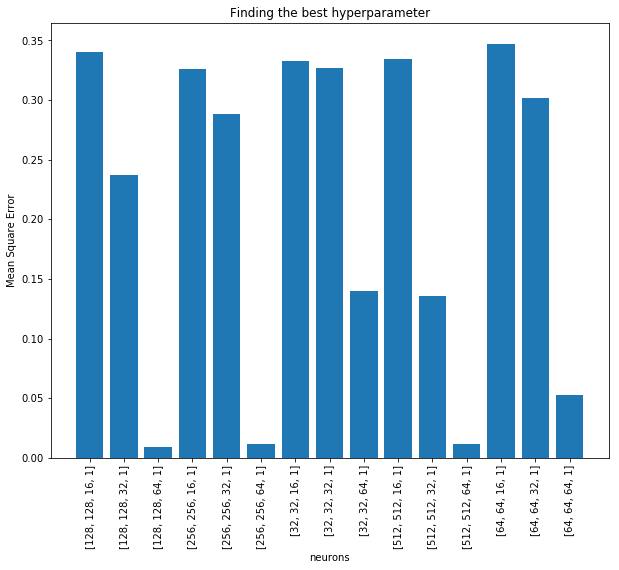

In [80]:
lists = sorted(neurons_result.items())
x,y = zip(*lists)

plt.title('Finding the best hyperparameter')
plt.xlabel('neurons')
plt.ylabel('Mean Square Error')

plt.bar(range(len(lists)), y, align='center')
plt.xticks(range(len(lists)), x)
plt.xticks(rotation=90)

plt.show()

Optimial Dropout value

In [83]:
batch_size = 512
shape = [4, window_size, 1] # feature, window, output
neurons = [128, 128, 64, 1]
epochs = 70
decaylist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
d = 0.7

In [84]:
def build_model2(layers, neurons, d, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [85]:
def quick_measure(file_csv_name, window_size, d, shape, neurons, epochs, decay):
    df = get_stock_price(file_csv_name)
    X_train, y_train, X_test, y_test = load_data(df, window_size)
    model = build_model2(shape, neurons, d, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [86]:
decay_result = {}

for decay in decaylist:    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs, decay)
    decay_result[decay] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_161 (LSTM)              (None, 120, 128)          68096     
_________________________________________________________________
dropout_161 (Dropout)        (None, 120, 128)          0         
_________________________________________________________________
lstm_162 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_162 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Trai

310/310 [==============================] - 41s - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.1273 - val_acc: 0.0000e+00
Epoch 36/70
310/310 [==============================] - 43s - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.1173 - val_acc: 0.0000e+00
Epoch 37/70
310/310 [==============================] - 43s - loss: 0.0094 - acc: 0.0000e+00 - val_loss: 0.1066 - val_acc: 0.0000e+00
Epoch 38/70
310/310 [==============================] - 43s - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.0966 - val_acc: 0.0000e+00
Epoch 39/70
310/310 [==============================] - 43s - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.0882 - val_acc: 0.0000e+00
Epoch 40/70
310/310 [==============================] - 42s - loss: 0.0092 - acc: 0.0000e+00 - val_loss: 0.0823 - val_acc: 0.0000e+00
Epoch 41/70
310/310 [==============================] - 42s - loss: 0.0090 - acc: 0.0000e+00 - val_loss: 0.0799 - val_acc: 0.0000e+00
Epoch 42/70
310/310 [==============================] - 42s - loss: 0.0086 - acc: 

Train on 310 samples, validate on 35 samples
Epoch 1/70
310/310 [==============================] - 117s - loss: 0.1193 - acc: 0.0000e+00 - val_loss: 0.5414 - val_acc: 0.0000e+00
Epoch 2/70
310/310 [==============================] - 40s - loss: 0.1145 - acc: 0.0000e+00 - val_loss: 0.5197 - val_acc: 0.0000e+00
Epoch 3/70
310/310 [==============================] - 42s - loss: 0.1082 - acc: 0.0000e+00 - val_loss: 0.4843 - val_acc: 0.0000e+00
Epoch 4/70
310/310 [==============================] - 41s - loss: 0.0996 - acc: 0.0000e+00 - val_loss: 0.4301 - val_acc: 0.0000e+00
Epoch 5/70
310/310 [==============================] - 39s - loss: 0.0855 - acc: 0.0000e+00 - val_loss: 0.3490 - val_acc: 0.0000e+00
Epoch 6/70
310/310 [==============================] - 39s - loss: 0.0641 - acc: 0.0000e+00 - val_loss: 0.2456 - val_acc: 0.0000e+00
Epoch 7/70
310/310 [==============================] - 40s - loss: 0.0341 - acc: 0.0000e+00 - val_loss: 0.1391 - val_acc: 0.0000e+00
Epoch 8/70
310/310 [==========

310/310 [==============================] - 60s - loss: 0.0090 - acc: 0.0000e+00 - val_loss: 0.0890 - val_acc: 0.0000e+00
Epoch 45/70
310/310 [==============================] - 52s - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0890 - val_acc: 0.0000e+00
Epoch 46/70
310/310 [==============================] - 55s - loss: 0.0084 - acc: 0.0000e+00 - val_loss: 0.0894 - val_acc: 0.0000e+00
Epoch 47/70
310/310 [==============================] - 63s - loss: 0.0077 - acc: 0.0000e+00 - val_loss: 0.0893 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 57s - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0873 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 55s - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0828 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 60s - loss: 0.0069 - acc: 0.0000e+00 - val_loss: 0.0763 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 62s - loss: 0.0071 - acc: 

310/310 [==============================] - 47s - loss: 0.0181 - acc: 0.0000e+00 - val_loss: 0.0362 - val_acc: 0.0000e+00
Epoch 9/70
310/310 [==============================] - 47s - loss: 0.0335 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 10/70
310/310 [==============================] - 46s - loss: 0.0225 - acc: 0.0000e+00 - val_loss: 0.0916 - val_acc: 0.0000e+00
Epoch 11/70
310/310 [==============================] - 51s - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.1325 - val_acc: 0.0000e+00
Epoch 12/70
310/310 [==============================] - 48s - loss: 0.0105 - acc: 0.0000e+00 - val_loss: 0.1650 - val_acc: 0.0000e+00
Epoch 13/70
310/310 [==============================] - 45s - loss: 0.0152 - acc: 0.0000e+00 - val_loss: 0.1834 - val_acc: 0.0000e+00
Epoch 14/70
310/310 [==============================] - 48s - loss: 0.0169 - acc: 0.0000e+00 - val_loss: 0.1884 - val_acc: 0.0000e+00
Epoch 15/70
310/310 [==============================] - 47s - loss: 0.0179 - acc: 0

310/310 [==============================] - 44s - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0272 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 45s - loss: 0.0050 - acc: 0.0000e+00 - val_loss: 0.0266 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 45s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0235 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 46s - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 55/70
310/310 [==============================] - 48s - loss: 0.0044 - acc: 0.0000e+00 - val_loss: 0.0128 - val_acc: 0.0000e+00
Epoch 56/70
310/310 [==============================] - 44s - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 57/70
310/310 [==============================] - 43s - loss: 0.0042 - acc: 0.0000e+00 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 58/70
310/310 [==============================] - 47s - loss: 0.0057 - acc: 

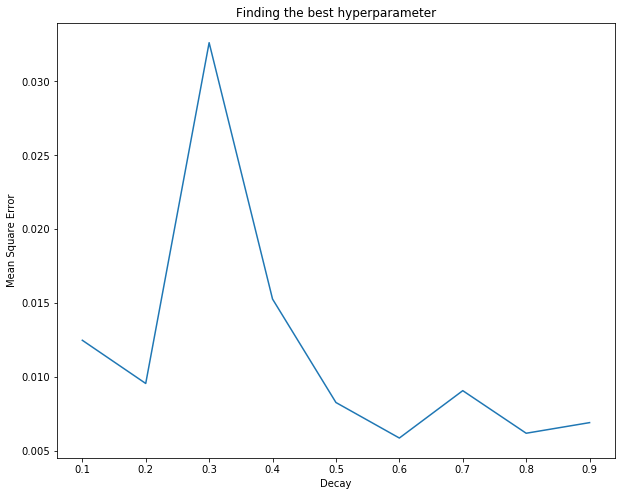

In [87]:
lists = sorted(decay_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Decay')
plt.ylabel('Mean Square Error')
plt.show()

hyperparameter window_size:

In [88]:
neurons = [128, 128, 64, 1]
epochs = 70
d = 0.7 #dropout
decay = 0.6

In [89]:
window_size_list = [5, 10, 22, 60, 120, 180]

window_size_result = {}

for window_size in window_size_list:
    shape = [4, window_size, 1]
    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs, decay)
    window_size_result[window_size] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 5, 128)            68096     
_________________________________________________________________
dropout_179 (Dropout)        (None, 5, 128)            0         
_________________________________________________________________
lstm_180 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_180 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Trai

399/399 [==============================] - 4s - loss: 0.0052 - acc: 0.0025 - val_loss: 0.0798 - val_acc: 0.0000e+00
Epoch 40/70
399/399 [==============================] - 4s - loss: 0.0050 - acc: 0.0025 - val_loss: 0.0741 - val_acc: 0.0000e+00
Epoch 41/70
399/399 [==============================] - 4s - loss: 0.0043 - acc: 0.0025 - val_loss: 0.0673 - val_acc: 0.0000e+00
Epoch 42/70
399/399 [==============================] - 4s - loss: 0.0045 - acc: 0.0025 - val_loss: 0.0600 - val_acc: 0.0000e+00
Epoch 43/70
399/399 [==============================] - 4s - loss: 0.0042 - acc: 0.0025 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 44/70
399/399 [==============================] - 4s - loss: 0.0041 - acc: 0.0025 - val_loss: 0.0478 - val_acc: 0.0000e+00
Epoch 45/70
399/399 [==============================] - 3s - loss: 0.0043 - acc: 0.0025 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 46/70
399/399 [==============================] - 3s - loss: 0.0042 - acc: 0.0025 - val_loss: 0.0420 - val_acc:

359/359 [==============================] - 24s - loss: 0.0825 - acc: 0.0000e+00 - val_loss: 0.3724 - val_acc: 0.0000e+00
Epoch 5/70
359/359 [==============================] - 25s - loss: 0.0701 - acc: 0.0000e+00 - val_loss: 0.2864 - val_acc: 0.0000e+00
Epoch 6/70
359/359 [==============================] - 25s - loss: 0.0493 - acc: 0.0000e+00 - val_loss: 0.1757 - val_acc: 0.0000e+00
Epoch 7/70
359/359 [==============================] - 24s - loss: 0.0224 - acc: 0.0000e+00 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 8/70
359/359 [==============================] - 28s - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0255 - val_acc: 0.0000e+00
Epoch 9/70
359/359 [==============================] - 28s - loss: 0.0365 - acc: 0.0000e+00 - val_loss: 0.0364 - val_acc: 0.0000e+00
Epoch 10/70
359/359 [==============================] - 24s - loss: 0.0243 - acc: 0.0000e+00 - val_loss: 0.0645 - val_acc: 0.0000e+00
Epoch 11/70
359/359 [==============================] - 24s - loss: 0.0113 - acc: 0.000

310/310 [==============================] - 54s - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 50s - loss: 0.0070 - acc: 0.0000e+00 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 49s - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0384 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 49s - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 50s - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 50s - loss: 0.0062 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 52s - loss: 0.0053 - acc: 0.0000e+00 - val_loss: 0.0227 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 51s - loss: 0.0047 - acc: 

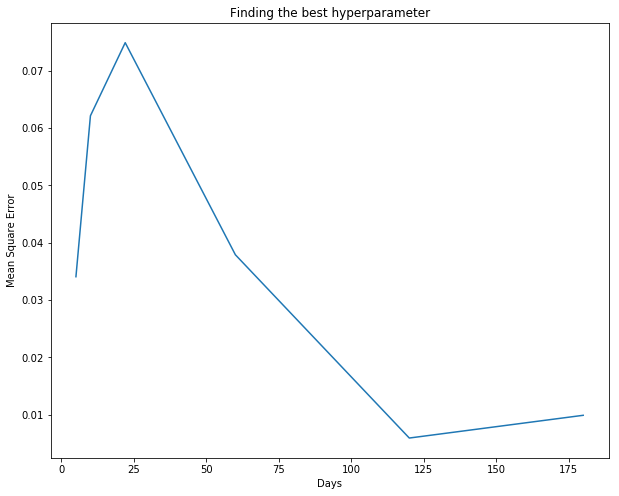

In [90]:
lists = sorted(seq_len_result.items()) # заменить на window_size_result
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Days')
plt.ylabel('Mean Square Error')
plt.show()